In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


In [2]:
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from string import punctuation
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV

### read csv file

In [3]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv', 
                 delimiter=',', encoding='ISO-8859-1')
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1048572 non-null  int64 
 1   id         1048572 non-null  int64 
 2   date       1048572 non-null  object
 3   query      1048572 non-null  object
 4   user       1048572 non-null  object
 5   text       1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [5]:
df.describe()

,sentiment,id
count,1.048572e+06,1.048572e+06
mean,9.482458e-01,1.976168e+09
std,1.701122e+00,2.300567e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.824526e+09
50%,0.000000e+00,1.990870e+09
75%,0.000000e+00,2.198903e+09
max,4.000000e+00,2.329206e+09


In [6]:
df.isnull().sum()

sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64

In [7]:
df['sentiment'] = df['sentiment'].replace({4:1})

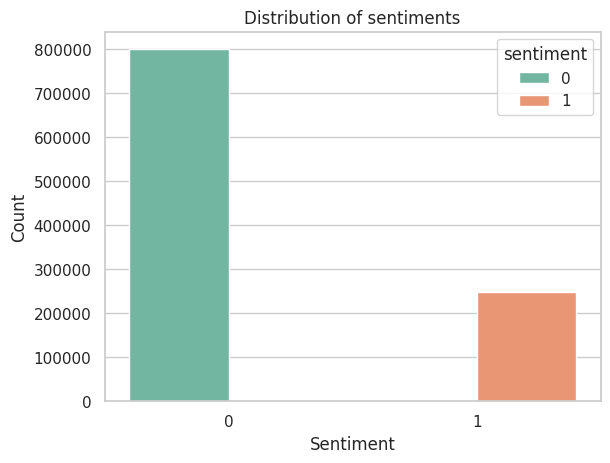

In [8]:
sns.set(style = 'whitegrid')
sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set2')
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of sentiments")
plt.show()

In [9]:
df['text'].isnull().sum()

0

In [10]:
df = df.drop_duplicates('text')

## preprocessing

In [11]:
stuff_to_be_removed = list(punctuation)
def textprocessing(text):
    text = str(text)
    text = text.lower()
    
    text = re.sub(r"https\S+|www\S+"," ",text,flags=re.MULTILINE)
    text = re.sub("(\\d|\\W)+"," ",text)       
    text = re.sub(r'\@\w+|\#'," ",text)                                         
    text = re.sub(r'[^\w\s\`]'," ",text)
    
    text_tokens = word_tokenize(text)
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text_tokens if not word in stuff_to_be_removed]
    text1 = " ".join(text)
    return text1

In [12]:
data_cleaned = pd.DataFrame()
df['text'] = df['text'].apply(textprocessing)
df['text'].head()

0    is upset that he can t updat his facebook by t...
1    kenichan i dive mani time for the ball manag t...
2         my whole bodi feel itchi and like it on fire
3    nationwideclass no it s not behav at all i m m...
4                          kwesidei not the whole crew
Name: text, dtype: object

In [13]:
neg_text = ' '.join(df[df['sentiment']==0]['text'])
pos_text = ' '.join(df[df['sentiment']==1]['text'])
df = df[['sentiment', 'text']]
df.head()

,sentiment,text
0,0,is upset that he can t updat his facebook by t...
1,0,kenichan i dive mani time for the ball manag t...
2,0,my whole bodi feel itchi and like it on fire
3,0,nationwideclass no it s not behav at all i m m...
4,0,kwesidei not the whole crew


## Visualizations

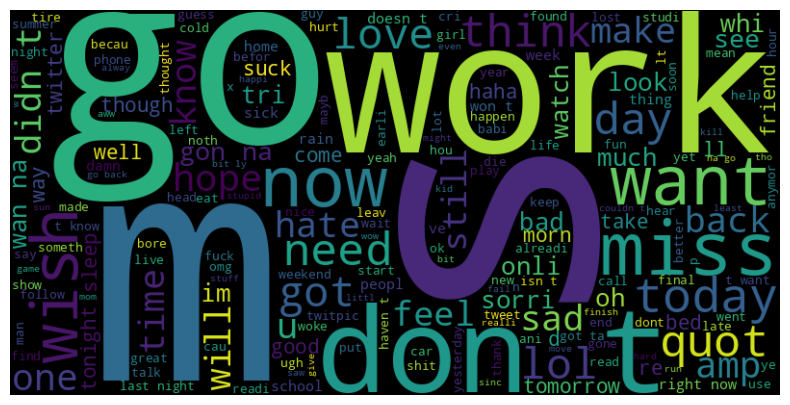

In [16]:
wc = WordCloud(width=800, height=400, background_color = 'black').generate(neg_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

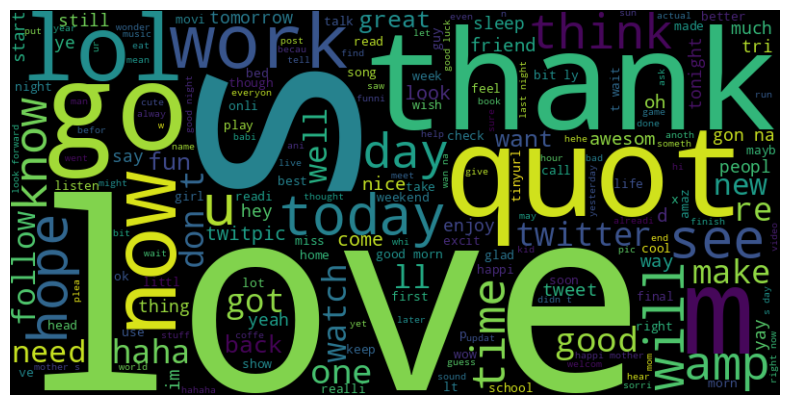

In [22]:
wc = WordCloud(width=800, height=400, background_color = 'black').generate(pos_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature scaling

In [14]:
x = df['text']
y = df['sentiment']
vectorizer = tf()
vectors = vectorizer.fit_transform(x) # to learn the vocab and transform the text data into a TF-IDF matrix

In [15]:
X_train_svm, X_temp_svm, y_train_svm, y_temp_svm = train_test_split(vectors, y, test_size=0.3, random_state=52)

X_val_svm, X_test_svm, y_val_svm, y_test_svm = train_test_split(X_temp_svm, y_temp_svm, test_size = 0.5, random_state= 52)

## SVM with PCA

In [17]:
n_components = 100
svd = TruncatedSVD(n_components = n_components)
X_train_svm_pca = svd.fit_transform(X_train_svm)
X_val_svm_pca = svd.transform(X_val_svm)
X_test_svm_pca = svd.transform(X_test_svm)

In [29]:
svm_model = LinearSVC(dual = True)
svm_model.fit(X_train_svm_pca, y_train_svm)

y_pred_val_svm = svm_model.predict(X_val_svm_pca)
acc_val_svm = accuracy_score(y_val_svm, y_pred_val_svm)
print(f"Accuracy on the validation set: {acc_val_svm}")

y_pred_test_svm = svm_model.predict(X_test_svm_pca)
acc_test_svm = accuracy_score(y_test_svm, y_pred_test_svm)
print(f"Accuracy on the validation set: {acc_test_svm}")

Accuracy on the validation set: 0.7909149401621413
Accuracy on the validation set: 0.7912623857933342


## SVM without PCA

In [30]:
classifier = CalibratedClassifierCV(LinearSVC(dual = True), method='sigmoid')
classifier.fit(X_train_svm, y_train_svm)

CalibratedClassifierCV(estimator=LinearSVC())

In [31]:
svm_predictions_train = classifier.predict(X_train_svm)

accuracy = accuracy_score(y_train_svm, svm_predictions_train)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_train_svm, svm_predictions_train))

Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94    553132
           1       0.90      0.72      0.80    172160

    accuracy                           0.91    725292
   macro avg       0.91      0.84      0.87    725292
weighted avg       0.91      0.91      0.91    725292



In [32]:
svm_prediction_test = classifier.predict(X_test_svm)


accuracy = accuracy_score(y_test_svm, svm_prediction_test)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_test_svm, svm_prediction_test))

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90    118493
           1       0.75      0.53      0.62     36927

    accuracy                           0.85    155420
   macro avg       0.81      0.74      0.76    155420
weighted avg       0.84      0.85      0.84    155420



In [33]:
svm_predictions_validation= classifier.predict(X_val_svm)

accuracy = accuracy_score(y_val_svm, svm_predictions_validation)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_val_svm, svm_predictions_validation))

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.90    118556
           1       0.75      0.53      0.62     36864

    accuracy                           0.85    155420
   macro avg       0.81      0.74      0.76    155420
weighted avg       0.84      0.85      0.84    155420



## Downsampling

In [18]:
df_majority_knn = df[df['sentiment']==0]
df_minority_knn = df[df['sentiment']==1]

df_majority_downsampled_knn = resample(df_majority_knn, 
                                 replace=False,   
                                 n_samples=len(df_minority_knn)//5,    
                                 random_state=134)

df_minority_downsampled_knn = resample(df_minority_knn, 
                                 replace=False,   
                                 n_samples=len(df_minority_knn)//5,    
                                 random_state=134)

In [19]:
df = pd.concat([df_majority_downsampled_knn, df_minority_downsampled_knn])

x = df['text']
y = df['sentiment']


vectorizer2 = tf()
vectors = vectorizer2.fit_transform(x)

vectors.shape

(98380, 79581)

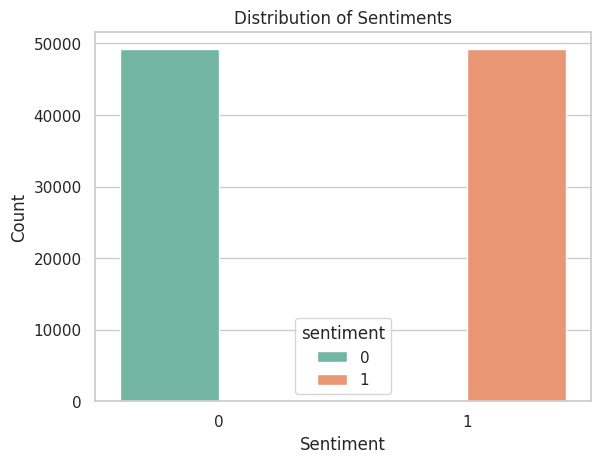

In [97]:
sns.set(style="whitegrid") 

sns.countplot(data=df, x='sentiment', hue='sentiment', palette='Set2')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

plt.show()

In [20]:
X_train_knn, X_temp_knn, y_train_knn, y_temp_knn = train_test_split(vectors, y, test_size=0.3, random_state=52)

X_validation_knn, X_test_knn, y_validation_knn, y_test_knn = train_test_split(X_temp_knn, y_temp_knn, test_size=0.5, random_state=52)

## KNN with PCA

In [21]:
n_components = 100  
svd = TruncatedSVD(n_components=n_components)
X_train_knn_pca = svd.fit_transform(X_train_knn)
X_validation_knn_pca = svd.transform(X_validation_knn)
X_test_knn_pca = svd.transform(X_test_knn)


knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(X_train_knn_pca, y_train_knn)


y_pred_validation_knn = knn_model.predict(X_validation_knn_pca)
accuracy_validation_knn = accuracy_score(y_validation_knn, y_pred_validation_knn)
print(f"Accuracy on the validation set: {accuracy_validation_knn}")

y_pred_test_knn = knn_model.predict(X_test_knn_pca)
accuracy_test_knn = accuracy_score(y_test_knn, y_pred_test_knn)
print(f"Accuracy on the test set: {accuracy_test_knn}")

Accuracy on the validation set: 0.6586704614759097
Accuracy on the test set: 0.6387477129497865


In [22]:
l = int(np.sqrt(len(x)))
print(l)

313


## KNN without PCA

In [23]:
knn_classifier = KNeighborsClassifier(n_neighbors=l)  # You can experiment with different values of k
knn_classifier.fit(X_train_knn, y_train_knn)


knn_predictions_train =knn_classifier.predict(X_train_knn) 
knn_accuracy = accuracy_score(y_train_knn, knn_predictions_train)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")
print(classification_report(y_train_knn, knn_predictions_train))

KNN Accuracy: 0.74
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77     34502
           1       0.81      0.63      0.71     34364

    accuracy                           0.74     68866
   macro avg       0.75      0.74      0.74     68866
weighted avg       0.75      0.74      0.74     68866



In [24]:
knn_prediction_test = knn_classifier.predict(X_test_knn) 
knn_accuracy = accuracy_score(y_test_knn, knn_prediction_test)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")
print(classification_report(y_test_knn, knn_prediction_test))

KNN Accuracy: 0.74
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.76      7324
           1       0.81      0.63      0.71      7433

    accuracy                           0.74     14757
   macro avg       0.75      0.74      0.74     14757
weighted avg       0.75      0.74      0.74     14757



In [25]:
knn_predictions_validation =knn_classifier.predict(X_validation_knn) 
knn_accuracy = accuracy_score(y_validation_knn, knn_predictions_validation)
print(f"KNN Accuracy: {knn_accuracy:.2f}")
print("KNN Classification Report:")

print(classification_report(y_validation_knn, knn_predictions_validation))

KNN Accuracy: 0.73
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      7364
           1       0.81      0.62      0.70      7393

    accuracy                           0.73     14757
   macro avg       0.75      0.74      0.73     14757
weighted avg       0.75      0.73      0.73     14757



In [26]:
def metrics(y_train, y_train_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=None)
    disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
    axes[0].set_title('Training Confusion Matrix ')

    
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=None)
    disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
    axes[1].set_title('Testing Confusion Matrix')

    plt.show()

## SVM ACC

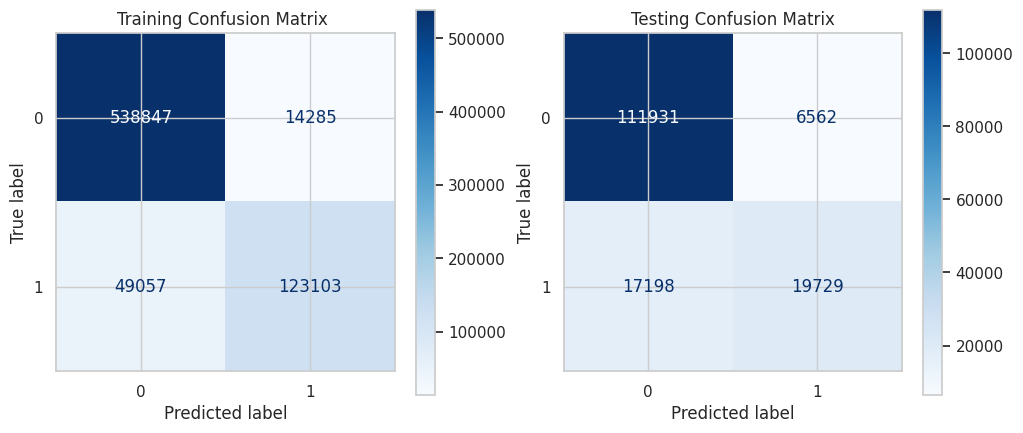

In [34]:
metrics(y_train_svm,svm_predictions_train ,y_test_svm,svm_prediction_test)

## KNN ACC

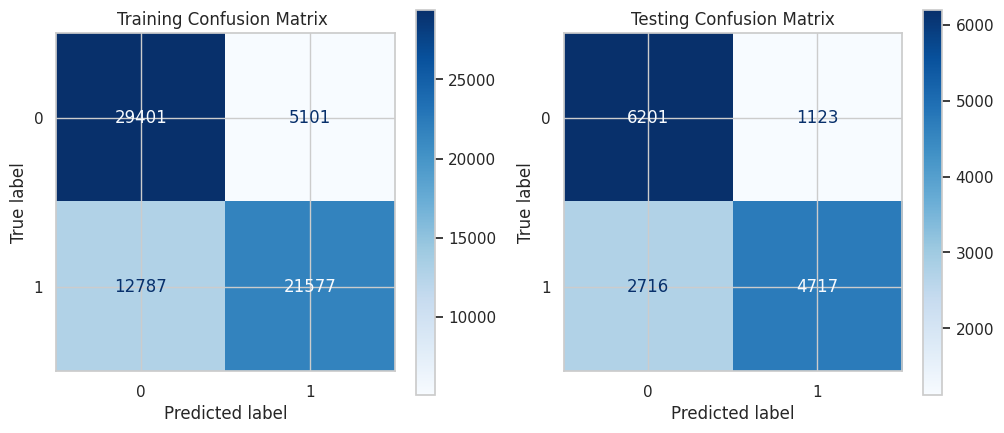

In [28]:
metrics(y_train_knn,knn_predictions_train ,y_test_knn,knn_prediction_test)

## ROC Curve of KNN, SVM

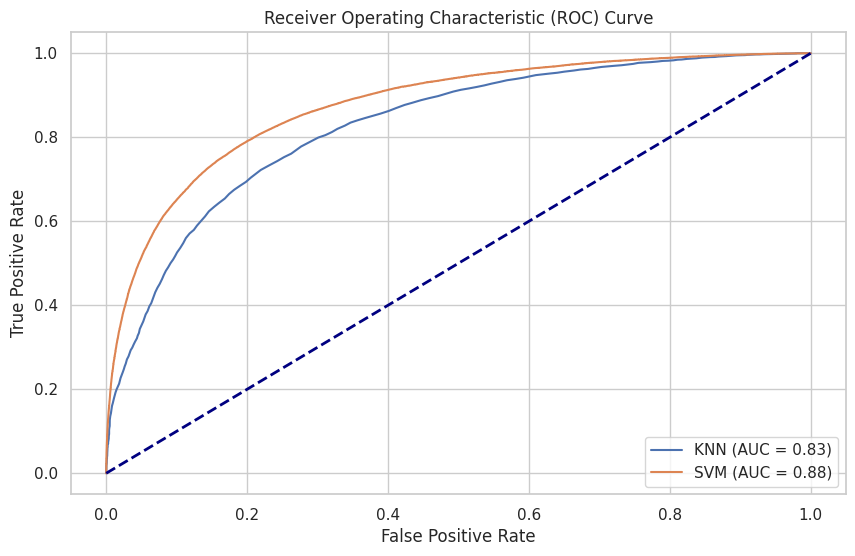

In [35]:
def plot_roc_curve(fpr, tpr, label, title):
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label, auc(fpr, tpr)))


plt.figure(figsize=(10, 6))

# KNN
knn_probs = knn_classifier.predict_proba(X_test_knn)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test_knn, knn_probs)
plot_roc_curve(knn_fpr, knn_tpr, 'KNN', 'ROC Curve - KNN')

# SVM
svm_probs = classifier.predict_proba(X_test_svm)[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test_svm, svm_probs)
plot_roc_curve(svm_fpr, svm_tpr, 'SVM', 'ROC Curve - SVM')

# Plotting diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()